##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# TF Hub for TF2: Image Module Retraining (preview)

<table align="left">
<td align="center">
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /><br>Run in Google Colab
  </a>
</td>
<td align="center">
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /><br>View source on GitHub</a>
</td>
</table>

This Colab demonstrates the use of TF2 SavedModels found on TensorFlow Hub with Keras. It uses a pre-trained image feature vector module for classifying five species of flowers, including fine-tuning of the module.

## Set up TensorFlow 2 and other libraries

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
%load_ext tensorboard


In [2]:
import itertools
import os
import re
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import pathlib

import pandas as pd

import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input #
from keras.layers import Reshape,Flatten
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Using TensorFlow backend.


TF version: 2.0.0
Hub version: 0.6.0
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [3]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299)


## Set up the dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = pathlib.Path('../dataset/Dataset_Img299')
data_dir=str(data_dir)

In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",seed=9001)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",seed=9001)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)
train_generator = test_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=False, **dataflow_kwargs)

Found 25199 images belonging to 2 classes.
Found 100801 images belonging to 2 classes.


## Train Data for Image

In [6]:
data_dir = "../dataset/Dataset_Img299/train"
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear"
                      )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=True,seed=9001, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=5,
      horizontal_flip=False,
      width_shift_range=0.1, height_shift_range=0.1,
      shear_range=0.1, zoom_range=0.1,
      **datagen_kwargs)
else:
    train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 20148 images belonging to 51 classes.
Found 80656 images belonging to 51 classes.


### Audio Input

In [7]:
data_dir_audio = "../dataset/Dataset_neg10db/train"
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator_audio = valid_datagen.flow_from_directory(
    data_dir_audio, subset="validation", seed=9001, shuffle=True, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen_audio = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=5,
      horizontal_flip=False,
      width_shift_range=0.1, height_shift_range=0.1,
      shear_range=0.1, zoom_range=0.1,
      **datagen_kwargs)
else:
    train_datagen_audio = valid_datagen
train_generator_audio = train_datagen_audio.flow_from_directory(
    data_dir_audio, subset="training", shuffle=True, **dataflow_kwargs)

Found 20148 images belonging to 51 classes.
Found 80656 images belonging to 51 classes.


## Combining the inputs

In [8]:
def generate_generator_multiple_fromgen(genX1,genX2):
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
training_generator = generate_generator_multiple_fromgen(train_generator,train_generator_audio)
val_generator = generate_generator_multiple_fromgen(valid_generator,valid_generator_audio) 


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [9]:
do_fine_tuning = False #@param {type:"boolean"}

In [10]:
from keras.utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
import tensorflow.keras
import tensorflow_hub as hub

In [11]:
print("Building model with", MODULE_HANDLE)
model_image = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model_image.build((None,)+IMAGE_SIZE+(3,))

# saved_model_path = "../unimodal-image/unimodal_ep_10"
# model_image = tf.keras.models.load_model(saved_model_path)

model_image.summary()
# plot_model(model, to_file='multiple_inputs.png')

# print("Building model with", MODULE_HANDLE)
# model = tf.keras.Sequential([
#     hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
#                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# ])
# model.build((None,)+IMAGE_SIZE+(3,))
# model.summary()
# plot_model(model, to_file='multiple_inputs.png')

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  104499    
Total params: 21,907,283
Trainable params: 104,499
Non-trainable params: 21,802,784
_________________________________________________________________


In [12]:
print("Building model with", MODULE_HANDLE)
model_speech = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning,name="speech_inceptionv3"),
    tf.keras.layers.Dropout(rate=0.5,name="sp_droput"),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)
                         ,name="sp_dense")
])
model_speech.build((None,)+IMAGE_SIZE+(3,))

# saved_model_path = "../unimodal-speech/saved_uni_speech_neg10db_ep_11"
# model_speech = tf.keras.models.load_model(saved_model_path)
model_speech.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speech_inceptionv3 (KerasLay multiple                  21802784  
_________________________________________________________________
sp_droput (Dropout)          multiple                  0         
_________________________________________________________________
sp_dense (Dense)             multiple                  104499    
Total params: 21,907,283
Trainable params: 104,499
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
saved_model_path = "../unimodal-image/unimodal_ep_10"
model_image = tf.keras.models.load_model(saved_model_path)
model_image.get_layer(name="keras_layer")._name="image_inception"
model_image.summary()

saved_model_path = "../unimodal-speech/saved_uni_speech_neg10db_ep_11"
model_speech = tf.keras.models.load_model(saved_model_path)
model_speech.get_layer(name="keras_layer")._name="speech_inception"
model_speech.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_inception (KerasLayer) multiple                  21802784  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  104499    
Total params: 21,907,283
Trainable params: 21,872,851
Non-trainable params: 34,432
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speech_inception (KerasLayer multiple                  21802784  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
___________________

In [14]:
visible1 = tf.keras.layers.Input(shape=(299,299,3),name='inputs_image')
visible2 = tf.keras.layers.Input(shape=(299,299,3),name='inputs_speech')
image_layer = model_image.get_layer(name="image_inception")(visible1)
speech_layer = model_speech.get_layer(name="speech_inception")(visible2)
merge = tf.keras.layers.Concatenate()([image_layer, speech_layer])


In [15]:
model_speech.get_weights()[-1]

array([-0.01455281,  0.00385032,  0.04114235,  0.00133997,  0.01450984,
        0.03542826,  0.0262791 , -0.01401053,  0.0062326 , -0.01464825,
       -0.01042568,  0.00420985, -0.03297416, -0.02337099,  0.01801716,
        0.0259285 , -0.00309212, -0.01033847,  0.03711404, -0.01992358,
       -0.02221184, -0.01084856,  0.02575624, -0.00825061, -0.02332988,
       -0.00318827,  0.00955004,  0.011067  , -0.01473341, -0.01410605,
        0.00915132,  0.00739494,  0.01820531, -0.01538785,  0.02408353,
       -0.00718953,  0.02231478, -0.02659764, -0.01115894,  0.01197988,
       -0.00848714, -0.0229668 ,  0.02034476, -0.01576074, -0.00310957,
        0.00884486,  0.05098232, -0.02226563, -0.01110399, -0.03263652,
       -0.01705761], dtype=float32)

In [16]:
model_image.get_weights()[-1]

array([ 0.01431655, -0.01690328,  0.22218959, -0.03231002,  0.06128773,
        0.07804259,  0.10214737, -0.02212401,  0.02702376, -0.00169531,
        0.02333045, -0.0312476 , -0.07065172, -0.03708483, -0.00392942,
        0.05300407, -0.04522814,  0.00033684,  0.18199457, -0.02851087,
       -0.00366588, -0.01276786,  0.0499532 , -0.02096   , -0.0191227 ,
       -0.06497081, -0.03252672, -0.02499443, -0.01426385, -0.04676826,
       -0.03593004, -0.04302249, -0.029481  , -0.01229884,  0.10121144,
       -0.01363244,  0.00943026, -0.07333084, -0.03750512, -0.01329186,
       -0.02026603, -0.03032868, -0.01528642, -0.02506783, -0.03484896,
        0.04185735,  0.1481697 , -0.03442311, -0.0398784 , -0.04836973,
       -0.07760864], dtype=float32)

In [17]:
# visible1 = tf.keras.layers.Input(shape=(299,299,3),name='inputs_image')
# visible2 = tf.keras.layers.Input(shape=(299,299,3),name='inputs_speech')

# # m = hub.Module(MODULE_HANDLE)

# # module = tf.keras.layers.TimeDistributed(hub.KerasLayer(hub.Module(use_url)))(seq)

# feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", 
#                         trainable=do_fine_tuning,
#                         input_shape=(299, 299, 3)
#                         )(visible1)

# feature_extractor_layer2 = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", 
#                         trainable=do_fine_tuning,
#                         input_shape=(299, 299, 3)
#                         )(visible2)

# merge = tf.keras.layers.Concatenate()([feature_extractor_layer, feature_extractor_layer2])
dropout1 = tf.keras.layers.Dropout(rate=0.2)(merge)

x= tf.keras.layers.BatchNormalization()(dropout1)
# x= tf.keras.layers.BatchNormalization()(feature_extractor_layer)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(51, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
pred =  tf.keras.layers.Dense(51, activation='softmax')(x)

In [18]:
# model =  tf.keras.Model(visible1, pred) #unimodal
model =  tf.keras.Model(inputs=[visible1, visible2], outputs=pred) #bimodal
# plot_model(model, to_file='multiple_inputs.png')
from sklearn.utils import compute_class_weight
class_weights=compute_class_weight(class_weight='balanced',
                                  classes=np.unique(train_generator.classes),
                                  y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
# classWeight = compute_class_weight('balanced', outputLabels, outputs) 
# classWeight = dict(enumerate(classWeight))
# model.fit(X_train, y_train, batch_size = batch_size, 
#           nb_epoch = nb_epochs, show_accuracy = True, 
#           verbose = 2, validation_data = (X_test, y_test), class_weight=classWeight)
model.get_layer("image_inception").trainable=False
model.get_layer("speech_inception").trainable=False

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True),
  loss=tf.keras.losses.CategoricalCrossentropy(),
metrics=['accuracy'])    
# metrics=[accuracy_metric, top5_accuracy_metric])    
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#   metrics=['accuracy'])

# resnet50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
#                  metrics=[accuracy_metric, top5_accuracy_metric])
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# history = model.fit(train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
#                        validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
#                        verbose=0, callbacks=callbacks)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_image (InputLayer)       [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inputs_speech (InputLayer)      [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
image_inception (KerasLayer)    (None, 2048)         21802784    inputs_image[0][0]               
__________________________________________________________________________________________________
speech_inception (KerasLayer)   (None, 2048)         21802784    inputs_speech[0][0]              
______________________________________________________________________________________________

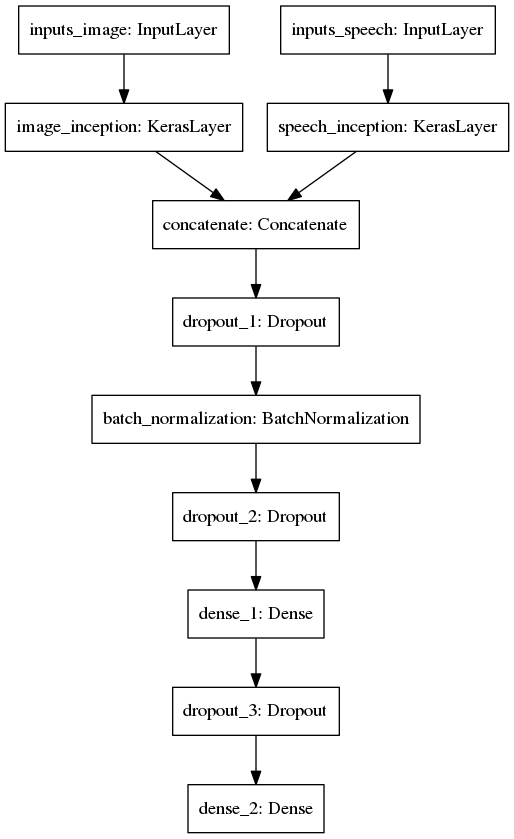

In [19]:
tf.keras.utils.plot_model(model,'test.png')

In [ ]:
epochs = 150
temp_hist=[]
for ep in range(epochs):
    hist = model.fit_generator(
#     train_generator,#unimodal
    training_generator, #bimodal
    epochs=1, steps_per_epoch=steps_per_epoch,
#     validation_data=valid_generator, #unimodal
    validation_data=val_generator, #bimodal
    validation_steps=validation_steps,verbose=1,
    workers=16,use_multiprocessing=True,
    class_weight=class_weight_dict
#         ,callbacks=callbacks
    ).history  
    temp_hist.append(hist) #if temp_hist is list
    saved_model_path = "./bimodal_inceptionv3_pretrained_ep_" + str(ep)
    model.save(saved_model_path +".h5")
    hist_df = pd.DataFrame(temp_hist)  #if temp_hist is list
    hist_df.to_csv('bimodal_inceptionv3_pretrained.csv')     #if temp_hist is list

In [ ]:
# NUM_CLASSES=4
# BATCH_SIZE=BATCH_SIZE
EPOCHS=100

In [ ]:
# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
# first input model
visible1 = Input(shape=(299,299,3),name='inputs_image')
x_1=Conv2D(filters=64,kernel_size=3,padding='same')(visible1)
x_1=MaxPooling2D()(x_1)
x_2=Conv2D(filters=128,kernel_size=8,padding='same')(visible1)
x_2=MaxPooling2D()(x_2)
x_3=Conv2D(filters=256,kernel_size=13,padding='same')(visible1)
x_3=MaxPooling2D()(x_3)
x=Concatenate()([x_1,x_2,x_3])

#x=Add()([x,short_cut])
x=BatchNormalization()(x)
x=Conv2D(filters=64,kernel_size=16)(x)

out_img = MaxPooling2D()(x)
flat1 = Flatten()(out_img)


# second input model
visible2 = Input(shape=(299,299,1),name='inputs_mfcc')

conv21 = Conv2D(32, kernel_size=4, activation='relu')(visible2)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
conv22 = Conv2D(16, kernel_size=4, activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
flat2 = Flatten()(pool22)
# # merge input models
merge = concatenate([flat1, flat2])
# # interpretation model
dropout1 = Dropout(rate=0.2)(merge)

# # hidden1 = Dense(10, activation='relu')(merge)
hidden1 = Dense(51, activation='relu')(dropout1)

dropout2 = Dropout(rate=0.2)(hidden1)
# #     tf.keras.layers.Dropout(rate=0.2),
# #     tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
# #                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# # output = Dense(1, activation='sigmoid')(hidden2)
output = Dense(51, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout2)
model = Model(inputs=[visible1, visible2], outputs=output)
# summarize layers
print(merged_model.summary())
# plot graph
plot_model(merged_model, to_file='multiple_inputs.png')

In [40]:
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 299, 299, 1)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 296, 296, 32) 1568        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 296, 296, 32) 544         input_4[0][0]                    
____________________________________________________________________________________________

In [61]:
# from keras.utils.training_utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=2)
from sklearn.utils import compute_class_weight
class_weights=compute_class_weight(class_weight='balanced',
                                  classes=np.unique(train_generator.classes),
                                  y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
# classWeight = compute_class_weight('balanced', outputLabels, outputs) 
# classWeight = dict(enumerate(classWeight))
# model.fit(X_train, y_train, batch_size = batch_size, 
#           nb_epoch = nb_epochs, show_accuracy = True, 
#           verbose = 2, validation_data = (X_test, y_test), class_weight=classWeight)

## Training the model

In [69]:
# model.compile(
#   optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True),
  loss=tf.keras.losses.CategoricalCrossentropy(),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [70]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# steps_per_epoch = training_generator.samples // training_generator.batch_size
# validation_steps = val_generator.samples // val_generator.batch_size

# steps_per_epoch = 100801 // 32
# validation_steps = 25199 // 32
# validation_steps = test_imgen.samples // test_imgen.batch_size

In [71]:
print(steps_per_epoch)
print(validation_steps)


2520
629


In [72]:
epochs = 100
temp_hist = []

In [ ]:
# hist = model.fit_generator(training_generator,
# epochs=1, steps_per_epoch=steps_per_epoch,
# validation_data=val_generator,
# validation_steps=validation_steps,verbose=1,workers=4).history  
for ep in range(1,epochs):
    hist = model.fit_generator(
    training_generator,
    epochs=1, steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,verbose=1,
    workers=4,use_multiprocessing=True,
    class_weight=class_weight_dict).history  
#     temp_hist.append(hist,ignore_index=True)
    temp_hist.append(hist) #if temp_hist is list
    
#     print(hist)
    saved_model_path = "./bimodal_late_adam_nosmooth_amsgrad_ep" + str(ep)
#     tf.saved_model.save(model, saved_model_path)
    model.save(saved_model_path +".h5")

    hist_df = pd.DataFrame(temp_hist)  #if temp_hist is list
    hist_df.to_csv('train_bimodal_late_adam_nosmooth_amsgrad_log.csv')     #if temp_hist is list
#     temp_hist.to_csv('train_log.csv')     


Epoch 1/1
2520/2520 [==============================] - 3080s 1s/step - loss: 3.4523 - accuracy: 0.1125 - val_loss: 3.0922 - val_accuracy: 0.0402
Epoch 1/1
2520/2520 [==============================] - 3052s 1s/step - loss: 2.3157 - accuracy: 0.2652 - val_loss: 4.1276 - val_accuracy: 0.0556
Epoch 1/1
2520/2520 [==============================] - 3049s 1s/step - loss: 1.4664 - accuracy: 0.4229 - val_loss: 6.7765 - val_accuracy: 0.0648
Epoch 1/1
2520/2520 [==============================] - 3048s 1s/step - loss: 1.0063 - accuracy: 0.5554 - val_loss: 8.0277 - val_accuracy: 0.0934
Epoch 1/1
2520/2520 [==============================] - 3077s 1s/step - loss: 0.7977 - accuracy: 0.6292 - val_loss: 15.6276 - val_accuracy: 0.1260
Epoch 1/1
1472/2520 [================>.............] - ETA: 19:07 - loss: 0.6857 - accuracy: 0.6739

In [26]:
model.save(saved_model_path +".h5")

# hist_df = pd.DataFrame(temp_hist)  #if temp_hist is list
# hist_df.to_csv('train_bimodal_late_adam_log.csv')     #if temp_hist is list

In [29]:
saved_model_path = "./saved_lip_null_ep_" + str(ep)
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: ./saved_lip_null_ep_9/assets


INFO:tensorflow:Assets written to: ./saved_lip_null_ep_9/assets


In [28]:
print(temp_hist)

[{'loss': [2.316262753337687], 'val_loss': [2.3719793514530685], 'accuracy': [0.5353865], 'val_accuracy': [0.52523845]}, {'loss': [1.819408319894935], 'val_loss': [2.455325429503982], 'accuracy': [0.6993451], 'val_accuracy': [0.5309022]}, {'loss': [1.6879657605120673], 'val_loss': [2.310744246731502], 'accuracy': [0.74445575], 'val_accuracy': [0.57944155]}, {'loss': [1.6099599338661326], 'val_loss': [2.4728358858909063], 'accuracy': [0.7702421], 'val_accuracy': [0.5187301]}, {'loss': [1.5588393566224708], 'val_loss': [2.624276320202741], 'accuracy': [0.78682524], 'val_accuracy': [0.49880764]}, {'loss': [1.5191592816488921], 'val_loss': [2.472897128005096], 'accuracy': [0.79950136], 'val_accuracy': [0.53686404]}, {'loss': [1.4837063854236077], 'val_loss': [2.3960891182168678], 'accuracy': [0.8112473], 'val_accuracy': [0.57675874]}, {'loss': [1.4569287674841982], 'val_loss': [2.4842185424507517], 'accuracy': [0.8193714], 'val_accuracy': [0.5288653]}, {'loss': [1.4350209747379936], 'val_l

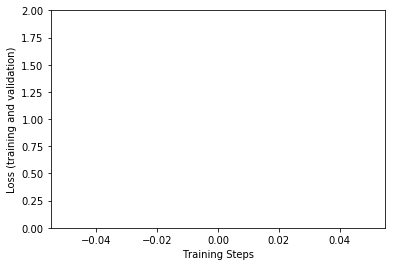

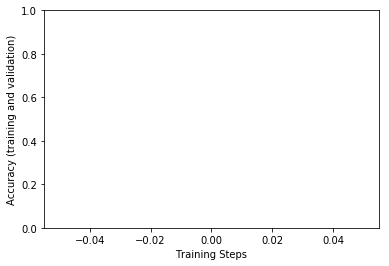

In [30]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [38]:
hist

{'accuracy': [0.82985216, 0.84089106, 0.8508385],
 'loss': [1.4290987213208197, 1.3962311056261618, 1.3634767802042203],
 'val_accuracy': [0.50039744, 0.53502584, 0.5633446],
 'val_loss': [2.695763185501857, 2.6466522813790934, 2.444194936695463]}

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [42]:
saved_model_path = "./saved_lip_null"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./saved_lip_fill/assets


INFO:tensorflow:Assets written to: ./saved_lip_fill/assets


In [ ]:
pred

In [ ]:
# model.evaluate_generator(generator=valid_generator,
# steps=STEP_SIZE_VALID)

# STEP_SIZE_TEST=valid_generator.n//valid_generator.batch_size
# valid_generator.reset()
# pred=model.predict_generator(valid_generator,
# steps=STEP_SIZE_TEST,
# verbose=1)

# predicted_class_indices=np.argmax(pred,axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]


filenames = valid_generator.filenames
nb_samples = len(filenames)

# # filenames = test_generator.filenames
# # nb_samples = len(filenames)

predict = model.predict_generator(valid_generator,steps = nb_samples,
verbose=1)
predicted_class_indices=np.argmax(predict,axis=1)

# model.predict_generator()

 5935/25196 [======>.......................] - ETA: 1:00:28

In [27]:
len(test_generator.filenames)

25199

In [31]:
test_dir = 'Dataset_Null/test'
# !ls

testgen_kwargs = dict(rescale=1./255, validation_split=.20)
testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    **testgen_kwargs)

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)

TEST_BATCH_SIZE = len(test_generator.filenames)

testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)


Found 25196 images belonging to 51 classes.
Found 25196 images belonging to 51 classes.


In [32]:

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples/BATCH_SIZE, verbose=True)

# filenames = valid_generator.filenames
# nb_samples = len(filenames)
# predict = model.predict_generator(valid_generator,steps = nb_samples,
# verbose=1)
# predicted_class_indices=np.argmax(predict,axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

# filenames=valid_generator.filenames
# results=pd.DataFrame({"Filename":filenames,
#                       "Predictions":predictions})
# results.to_csv("results.csv",index=False)

788/787 [==============================] - 226s 286ms/step


In [33]:
predicted_class_indices=np.argmax(predict,axis=1)

labels = (train_generator.class_indices)

In [34]:
labels = dict((v,k) for k,v in labels.items())

In [216]:
# predictions = [labels[k] for k in predicted_class_indices]
# results=pd.DataFrame({"Filename":filenames,
#                       "Predictions":predictions})
# results.to_csv("results.csv",index=False)
# label_df = pd.DataFrame.from_dict(labels, orient='index',columns=['str_label'])
# label_df.index.name='index'
labels[51]='Missing'  
def word_to_int(str_label):
    try:
        return int(label_df[label_df['str_label']==str_label].index.values[0])
    except:
        return None

In [35]:
predictions = [labels.get(k) for k in predicted_class_indices]
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_pred_null.csv",index=False)


In [36]:
results['label'] = results.apply(lambda x: x['Filename'].split('_')[2].split('.')[0], axis=1)
results.to_csv("results_pred_null2.csv",index=False)

# results['n_label'] = results.apply(lambda x: word_to_int(x['label']), axis=1)
# results[results['Predictions'].isna()] = 'Missing'


In [199]:
results['n_prediction'] = predicted_class_indices

In [254]:
results[results['n_label'].isnull()]['Filename']

Series([], Name: Filename, dtype: object)

In [253]:
results = results.drop(results.index[1218])

In [16]:
# results.to_csv(""results_pred2".csv",index=False)
results = pd.read_csv("results_pred_Null.csv")

In [18]:
results

,Filename,Predictions,label,n_label,n_prediction
0,a/s10_lbaa2n_a.jpg,e,a,0.0,9
1,a/s10_lbaa3s_a.jpg,l,a,0.0,21
2,a/s10_lbaa4p_a.jpg,e,a,0.0,9
3,a/s10_lbaa5a_a.jpg,white,a,0.0,45
4,a/s10_lbba6n_a.jpg,j,a,0.0,19
...,...,...,...,...,...
25191,zero/s16_briezs_zero.jpg,Missing,zero,50.0,51
25192,zero/s16_brirza_zero.jpg,Missing,zero,50.0,51
25193,zero/s16_brwszs_zero.jpg,soon,zero,50.0,39
25194,zero/s16_bwafzs_zero.jpg,Missing,zero,50.0,51


In [89]:
new_list = [str(labels.get(k)) for k in predicted_class_indices]


In [38]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report,mean_squared_error
import seaborn as sns; sns.set()


/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [138]:
  

# label_df = pd.DataFrame.from_dict(labels, orient='index',columns=['str_label'])
# label_df.index.name='index'
# word_to_int = dict((c,i) for i,c in enumerate(word_map))
#     #print(word_to_int)
#     int_to_word = dict((i,c) for i,c in enumerate(word_map))
#     #print(target[1])
#     #print(word_to_int[target[1]])
#     interger_encoded = [word_to_int[word] for word in label]
    
#     onehot_encoded = list()
#     for value in interger_encoded:
#         letter = [0 for _ in range(len(word_map))]
#         letter[value] = 1
#         onehot_encoded.append(letter)
#     result = np.asarray(onehot_encoded,dtype = np.int32)

In [208]:
# predicted_class_indices
results.n_label
# word_map = ['bin','lay','place','set',
#            'blue','red','green','white',
#            'at','in','with','by',
#            'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','x','y','z',
#            'zero','one','two','three','four','five','six','seven','eight','nine',
#            'again','now','soon','please']
# word_to_int = dict((c,i) for i,c in enumerate(word_map))
# #print(word_to_int)
# int_to_word = dict((i,c) for i,c in enumerate(word_map))
# #print(target[1])
# #print(word_to_int[target[1]])
# interger_encoded = [word_to_int[word] for word in label]

0         0
1         0
2         0
3         0
4         0
         ..
25192    50
25193    50
25194    50
25195    50
25196    50
Name: n_label, Length: 25197, dtype: object

In [24]:
# from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
from sklearn.metrics import classification_report
# con_mat = tf.math.confusion_matrix(
#     labels=results.n_label,
#     predictions=results.n_prediction)
    
#     num_classes=None,
#     weights=None,
#     dtype=tf.dtypes.string,
#     name=None
# )
# con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
# con_mat_df = pd.DataFrame(con_mat_norm,
#                      index = classes, 
#                      columns = classes)
conf_matrix = confusion_matrix(y_true=results.n_label, y_pred=results.n_prediction)
print('\nClassification Report:\n', classification_report(y_true=results.n_label, y_pred=results.n_prediction, labels=))
# x_axis_labels = ['GB','US'] # labels for x-axis
# y_axis_labels = ['GB','US'] # labels for y-axis

# ax = sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="YlGnBu")
#                  , 
#                  xticklabels=x_axis_labels, yticklabels=y_axis_labels)


Classification Report:
              precision    recall  f1-score   support

        0.0       0.45      0.24      0.31       168
        1.0       0.88      0.65      0.75      1050
        2.0       0.50      0.29      0.36      1049
        3.0       0.55      0.25      0.34       168
        4.0       0.76      0.72      0.74      1056
        5.0       0.44      0.92      0.60      1050
        6.0       0.76      0.75      0.76      1048
        7.0       0.22      0.04      0.06       168
        8.0       0.17      0.01      0.01       168
        9.0       0.21      0.11      0.15       168
       10.0       0.26      0.16      0.20       420
       11.0       0.82      0.52      0.64       168
       12.0       0.88      0.61      0.72       420
       13.0       0.58      0.90      0.70       420
       14.0       0.16      0.32      0.21       168
       15.0       0.42      0.53      0.47      1050
       16.0       0.34      0.60      0.44       168
       17.0       0.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(y_true=results.label, y_pred=results.Predictions)
print('\nClassification Report:\n', classification_report(y_true=results.label, y_pred=results.Predictions))



Classification Report:
              precision    recall  f1-score   support

          a       0.40      0.25      0.31       168
      again       0.80      0.49      0.60      1050
         at       0.42      0.33      0.37      1049
          b       0.42      0.11      0.18       168
        bin       0.46      0.79      0.58      1056
       blue       0.70      0.66      0.68      1050
         by       0.56      0.90      0.69      1048
          c       0.31      0.02      0.04       168
          d       0.33      0.06      0.10       168
          e       0.39      0.07      0.12       168
      eight       0.34      0.08      0.13       420
          f       0.66      0.60      0.63       168
       five       0.56      0.63      0.59       420
       four       0.57      0.78      0.66       420
          g       0.14      0.23      0.18       168
      green       0.45      0.84      0.58      1050
          h       0.36      0.52      0.42       168
          i       0.

In [41]:
import seaborn as sns

In [40]:
results.Predictions.unique()

array(['e', 'l', 'white', 'j', 'a', 'x', 'two', 'at', 'one', 'v', 'again',
       'now', 'by', 'r', 'in', 'eight', 'bin', 'nine', 's', 'm', 'green',
       'five', 'o', 't', 'n', 'soon', 'blue', 'four', 'd', 'g', 'three',
       'with', 'p', 'u', 'Missing', 'h', 'q', 'seven', 'please', 'y',
       'set', 'lay', 'red', 'b', 'place', 'c', 'zero', 'six', 'f', 'k',
       'z'], dtype=object)

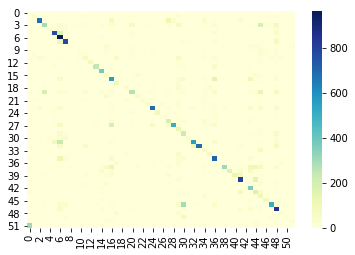

In [44]:
ax = sns.heatmap(conf_matrix,annot=False,fmt="d",cmap="YlGnBu"
                 , xticklabels='auto', yticklabels='auto')
#                  xticklabels=x_axis_labels, yticklabels=y_axis_labels)

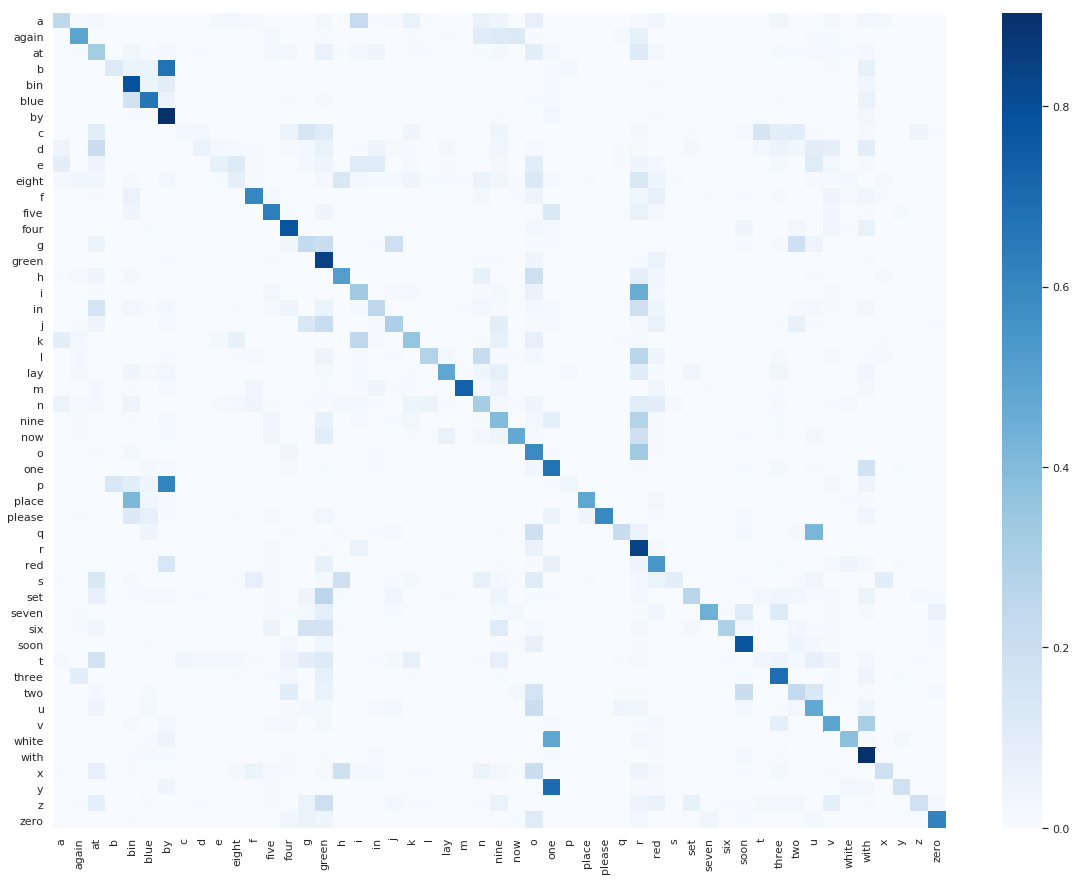

In [44]:
plt.subplots(figsize=(20,15))

cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm,annot=False,fmt="d",cmap=plt.cm.Blues,annot_kws={"size": 16},
                xticklabels=results.label.unique(),yticklabels=results.label.unique())

In [25]:
labels

NameError: name 'labels' is not defined

In [46]:
filenames = valid_generator.filenames
nb_samples = len(filenames)
nb_samples

20148

In [49]:
len(predictions)


644364

## Load Saved Model

In [14]:
# saved_model_path = "./saved_lip_fill"
saved_model_path = "./saved_lip_null_ep_9"

In [15]:
saved_model_path = "./saved_lip_null_ep_9"
model = tf.keras.models.load_model(saved_model_path)

# model = tf.saved_model.load(
#     export_dir=saved_model_path,
#     tags=None
# )

# model, saved_model_path

## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/tmp/lite_flowers_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

## MUltiple Inputs

In [6]:
# from tf.keras.preprocessing.image import ImageDataGenerator
input_imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   rotation_range=5.,
                                   horizontal_flip = False)

test_imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [7]:



def generate_generator_multiple(generator,dir1, dir2, batch_size, img_height,img_width):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_directory(dir2,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            

In [41]:
def generate_generator_multiple_fromgen(genX1,genX2):
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
input_traingen = generate_generator_multiple_fromgen(train_generator,train_generator_audio)
val_traingen = generate_generator_multiple_fromgen(valid_generator,valid_generator_audio)            

In [28]:
train_dir_1 = "../dataset/Dataset_Img299/train"
train_dir_2 = "../dataset/Dataset_neg20db/train"

In [29]:
img_height=299

In [30]:
# inputgenerator=generate_generator_multiple(generator=input_imgen,
#                                            dir1=train_dir_1,
#                                            dir2=train_dir_2,
#                                            batch_size=BATCH_SIZE,
#                                            img_height=img_height,
#                                            img_width=img_height)       
input_traingen = generate_generator_multiple_fromgen(train_generator,train_generator_audio)
val_traingen = generate_generator_multiple_fromgen(valid_generator,valid_generator_audio)
# testgenerator=generate_generator_multiple(test_imgen,
#                                           dir1=train_dir_1,
#                                           dir2=train_dir_2,
#                                           batch_size=batch_size,
#                                           img_height=img_height,
#                                           img_width=img_height)    

In [31]:
test_dir_1 = "../dataset/Dataset_Img299/test"
test_dir_2 = "../dataset/Dataset_neg20db/test"

testgenerator=generate_generator_multiple(test_imgen,
                                          dir1=test_dir_1,
                                          dir2=test_dir_2,
                                          batch_size=BATCH_SIZE,
                                          img_height=img_height,
                                          img_width=img_height)              

In [32]:

# history=model.fit_generator(inputgenerator,
#                         steps_per_epoch=trainsetsize/batch_size,
#                         epochs = epochs,
#                         validation_data = testgenerator,
#                         validation_steps = testsetsize/batch_size,
#                         use_multiprocessing=True,
#                         shuffle=False)
    
hist = model.fit_generator(inputgenerator,
epochs=1, steps_per_epoch=steps_per_epoch,
validation_data=testgenerator,
validation_steps=validation_steps,
use_multiprocessing=True,
verbose=1,workers=4).history  
#   temp_hist.append(hist,ignore_index=True)
# temp_hist.append(hist) #if temp_hist is list

#   print(hist)
# saved_model_path = "./bimodal_late_ep" + str(ep)
# tf.saved_model.save(model, saved_model_path)
# hist_df = pd.DataFrame(temp_hist)  #if temp_hist is list
# hist_df.to_csv('train_bimodal_early_log.csv')     #if temp_hist is list
#   temp_hist.to_csv('train_log.csv')     
    
    

Epoch 1/1
Found 25196 images belonging to 51 classes.
Epoch 1/1
Found 25196 images belonging to 51 classes.
Found 25196 images belonging to 51 classes.
Found 25196 images belonging to 51 classes.
Found 25201 images belonging to 51 classes.
Found 25201 images belonging to 51 classes.
Found 25201 images belonging to 51 classes.
Found 25201 images belonging to 51 classes.
Found 100804 images belonging to 51 classes.
Found 100804 images belonging to 51 classes.
Found 100804 images belonging to 51 classes.
Epoch 1/1
Found 100804 images belonging to 51 classes.
Found 100804 images belonging to 51 classes.
Found 100804 images belonging to 51 classes.
Found 100804 images belonging to 51 classes.
Found 100804 images belonging to 51 classes.
3150/3150 [==============================] - 3336s 1s/step - loss: 1.1921e-07 - accuracy: 0.0196 - val_loss: 1.1921e-07 - val_accuracy: 0.0196


In [26]:
# Learn more or give us feedback
# """
# File name: keras_custom_callbacks.py
# Author: Benjamin Planche
# Date created: 14.02.2019
# Date last modified: 14:49 14.02.2019
# Python Version: 3.6
# Copyright = "Copyright (C) 2018-2019 of Packt"
# Credits = ["Eliot Andres, Benjamin Planche"]
# License = "MIT"
# Version = "1.0.0"
# Maintainer = "non"
# Status = "Prototype" # "Prototype", "Development", or "Production"
# """

#==============================================================================
# Imported Modules
#==============================================================================
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import tensorflow as tf

#==============================================================================
# Class Definitions
#==============================================================================

class SimpleLogCallback(tf.keras.callbacks.Callback):
    """ Keras callback for simple, denser console logs."""

    def __init__(self, metrics_dict, num_epochs='?', log_frequency=1,
                 metric_string_template='\033[1m[[name]]\033[0m = \033[94m{[[value]]:5.3f}\033[0m'):
        """
        Initialize the Callback.
        :param metrics_dict:            Dictionary containing mappings for metrics names/keys
                                        e.g. {"accuracy": "acc", "val. accuracy": "val_acc"}
        :param num_epochs:              Number of training epochs
        :param log_frequency:           Log frequency (in epochs)
        :param metric_string_template:  (opt.) String template to print each metric
        """
        super().__init__()

        self.metrics_dict = collections.OrderedDict(metrics_dict)
        self.num_epochs = num_epochs
        self.log_frequency = log_frequency

        # We build a format string to later print the metrics, (e.g. "Epoch 0/9: loss = 1.00; val-loss = 2.00")
        log_string_template = 'Epoch {0:2}/{1}: '
        separator = '; '

        i = 2
        for metric_name in self.metrics_dict:
            templ = metric_string_template.replace('[[name]]', metric_name).replace('[[value]]', str(i))
            log_string_template += templ + separator
            i += 1

        # We remove the "; " after the last element:
        log_string_template = log_string_template[:-len(separator)]
        self.log_string_template = log_string_template

    def on_train_begin(self, logs=None):
        print("Training: \033[92mstart\033[0m.")

    def on_train_end(self, logs=None):
        print("Training: \033[91mend\033[0m.")

    def on_epoch_end(self, epoch, logs={}):
        if (epoch - 1) % self.log_frequency == 0 or epoch == self.num_epochs:
            values = [logs[self.metrics_dict[metric_name]] for metric_name in self.metrics_dict]
            print(self.log_string_template.format(epoch, self.num_epochs, *values))